# Movie Recommendation System

## Importing libraries

In [3]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import ast
import warnings
import pickle

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

In [4]:
warnings.filterwarnings("ignore")

## Loading datasets

In [5]:
credits = pd.read_csv("dataset/tmdb_5000_credits.csv")
movies = pd.read_csv("dataset/tmdb_5000_movies.csv")

## Exploritory Data Analysis (EDA)

### Movies Dataset

In [6]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [7]:
movies.shape

(4803, 20)

In [8]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [10]:
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [11]:
movies.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object

### Credits Dataset

In [12]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [13]:
credits.shape

(4803, 4)

In [14]:
credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [15]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [16]:
credits.describe()

,movie_id
count,4803.000000
mean,57165.484281
std,88694.614033
min,5.000000
25%,9014.500000
50%,14629.000000
75%,58610.500000
max,459488.000000


In [17]:
credits.dtypes

movie_id     int64
title       object
cast        object
crew        object
dtype: object

## Merging Two Datasets

**As we can see that both the datasets have "title" column common. Let's merge both the datasets and make a new new dataset.**

In [18]:
movies = movies.merge(credits, on="title")

## Exploritory Data Analysis (EDA) on Merged Dataset

In [19]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [20]:
movies.shape

(4809, 23)

In [21]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'movie_id', 'cast', 'crew'],
      dtype='object')

In [22]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

In [23]:
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id
count,4.809000e+03,4809.000000,4809.000000,4.809000e+03,4807.000000,4809.000000,4809.000000,4809.000000
mean,2.902780e+07,57120.571429,21.491664,8.227511e+07,106.882255,6.092514,690.331670,57120.571429
std,4.070473e+07,88653.369849,31.803366,1.628379e+08,22.602535,1.193989,1234.187111,88653.369849
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000
25%,7.800000e+05,9012.000000,4.667230,0.000000e+00,94.000000,5.600000,54.000000,9012.000000
50%,1.500000e+07,14624.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14624.000000
75%,4.000000e+07,58595.000000,28.350529,9.291317e+07,118.000000,6.800000,737.000000,58595.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000


In [24]:
movies.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
movie_id                  int64
cast                     object
crew                     object
dtype: object

**As we can see that both datasets merged successfully.**

## Removing unwanted columns and creating a new dataframe

In [25]:
movies = movies[["movie_id", "title", "overview", "genres", "keywords", "cast", "crew", "vote_average", "vote_count", "budget", "original_language", "release_date", "revenue", "runtime", "status", "production_companies", "production_countries", "popularity"]]

## Exploritory Data Analysis (EDA) on new dataframe

In [26]:
movies.isnull().sum()

movie_id                0
title                   0
overview                3
genres                  0
keywords                0
cast                    0
crew                    0
vote_average            0
vote_count              0
budget                  0
original_language       0
release_date            1
revenue                 0
runtime                 2
status                  0
production_companies    0
production_countries    0
popularity              0
dtype: int64

In [27]:
movies.dropna(inplace=True)

In [28]:
movies.isnull().sum()

movie_id                0
title                   0
overview                0
genres                  0
keywords                0
cast                    0
crew                    0
vote_average            0
vote_count              0
budget                  0
original_language       0
release_date            0
revenue                 0
runtime                 0
status                  0
production_companies    0
production_countries    0
popularity              0
dtype: int64

In [29]:
movies.duplicated().sum()

0

**There are no duplicate values in the dataframe, and we removed rows with missing values.**

## Cleaning Data

In [30]:
movies.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

**The data is a list of dictionary which contains some unwanted key-value pairs. Let's clean this data.**

In [31]:
def convert_data_format(data):
    new_data = []

    for i in ast.literal_eval(data):
        new_data.append(i["name"])

    return new_data

In [32]:
movies["genres"] = movies["genres"].apply(convert_data_format)

In [33]:
movies["genres"]

0       [Action, Adventure, Fantasy, Science Fiction]
1                        [Adventure, Fantasy, Action]
2                          [Action, Adventure, Crime]
3                    [Action, Crime, Drama, Thriller]
4                [Action, Adventure, Science Fiction]
                            ...                      
4804                        [Action, Crime, Thriller]
4805                                [Comedy, Romance]
4806               [Comedy, Drama, Romance, TV Movie]
4807                                               []
4808                                    [Documentary]
Name: genres, Length: 4805, dtype: object

**The data is cleaned now. Let's repeat this process for the other columns.**

In [34]:
movies["keywords"] = movies["keywords"].apply(convert_data_format)

In [35]:
def convert_cast_data_format(data):
    new_data = []
    counter = 0

    for i in ast.literal_eval(data):
        if counter < 3:
            new_data.append(i["name"])
            
            counter += 1
        else:
            break

    return new_data

In [36]:
movies["cast"] = movies["cast"].apply(convert_cast_data_format)

In [37]:
def convert_director_data_format(data):
    new_data = []

    for i in ast.literal_eval(data):
        if i["job"] == "Director":
            new_data.append(i["name"])

            break

    return new_data

In [38]:
movies["crew"] = movies["crew"].apply(convert_director_data_format)

In [39]:
movies["crew"]

0           [James Cameron]
1          [Gore Verbinski]
2              [Sam Mendes]
3       [Christopher Nolan]
4          [Andrew Stanton]
               ...         
4804     [Robert Rodriguez]
4805         [Edward Burns]
4806          [Scott Smith]
4807          [Daniel Hsia]
4808     [Brian Herzlinger]
Name: crew, Length: 4805, dtype: object

In [40]:
movies["overview"] = movies["overview"].apply(lambda x: x.split())

In [41]:
movies["overview"].iloc[0]

['In',
 'the',
 '22nd',
 'century,',
 'a',
 'paraplegic',
 'Marine',
 'is',
 'dispatched',
 'to',
 'the',
 'moon',
 'Pandora',
 'on',
 'a',
 'unique',
 'mission,',
 'but',
 'becomes',
 'torn',
 'between',
 'following',
 'orders',
 'and',
 'protecting',
 'an',
 'alien',
 'civilization.']

In [42]:
def convert_production_companies_data_format(data):
    new_data = []

    for i in ast.literal_eval(data):
        new_data.append(i.get("name", "None"))

    return new_data

In [43]:
movies["production_companies"] = movies["production_companies"].apply(convert_production_companies_data_format)

In [44]:
def convert_production_countries_data_format(data):
    new_data = []

    for i in ast.literal_eval(data):
        new_data.append(i.get("name", "None"))

    return new_data

In [45]:
movies["production_countries"] = movies["production_countries"].apply(convert_production_countries_data_format)

## Data Visualization

In [46]:
sb.set(rc={"figure.figsize": (15, 5)})

Text(0.5, 1.0, 'Top 10 Movie Genres by Count')

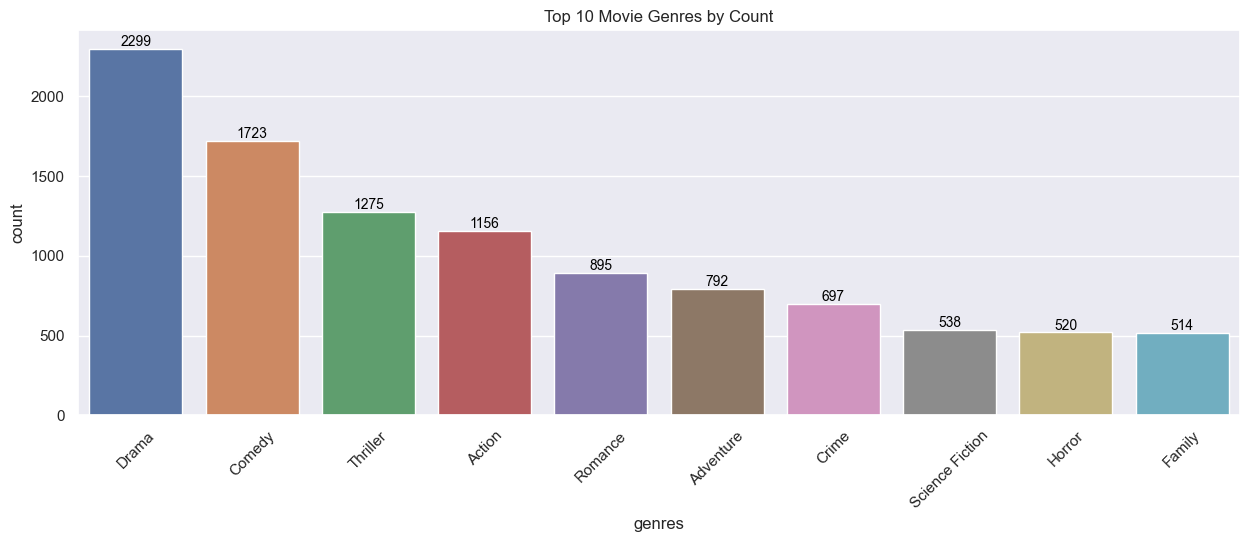

In [47]:
genres_df = pd.DataFrame({'genres': [genre for sublist in movies['genres'] for genre in sublist]})

genre_counts = genres_df['genres'].value_counts().sort_values(ascending=False)

top_genres = genre_counts.head(10).index

top_genres_df = genres_df[genres_df['genres'].isin(top_genres)]

ax1 = sb.countplot(x="genres", data=top_genres_df, order=top_genres)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

ax1.set_title("Top 10 Movie Genres by Count")

Text(0.5, 1.0, 'Top 10 Movie Languages by Count')

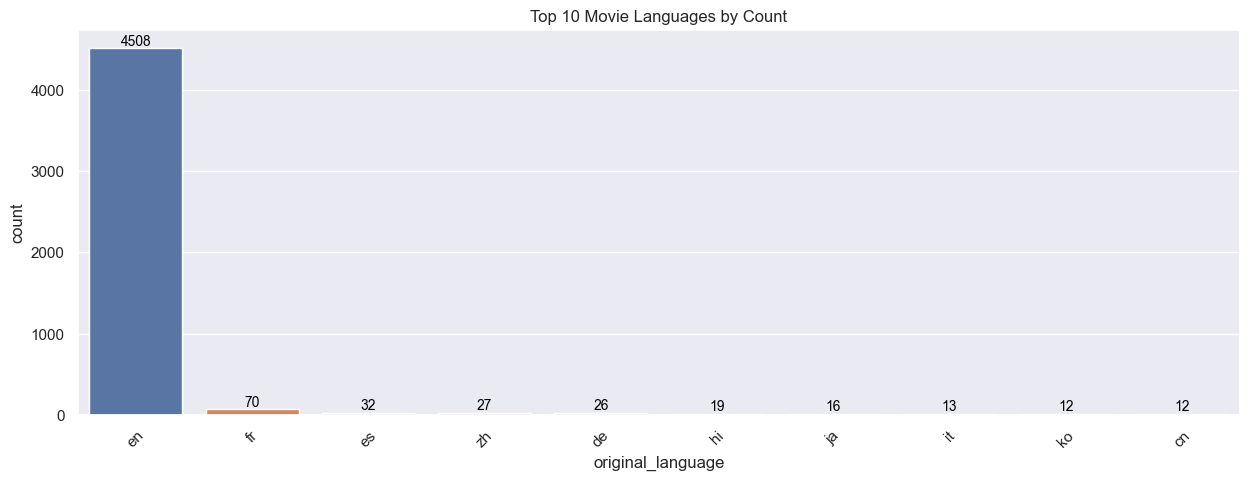

In [48]:
original_language_df = pd.DataFrame({'original_language': [language for language in movies['original_language']]})

original_language_counts = original_language_df['original_language'].value_counts().sort_values(ascending=False).head(10)

top_original_language = original_language_counts.index

top_original_language_df = original_language_df[original_language_df['original_language'].isin(top_original_language)]

ax2 = sb.countplot(x="original_language", data=top_original_language_df, order=top_original_language)

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

ax2.set_title('Top 10 Movie Languages by Count')

Text(0.5, 1.0, "Top 10 Movie Production Companies by Movie's Produced Count")

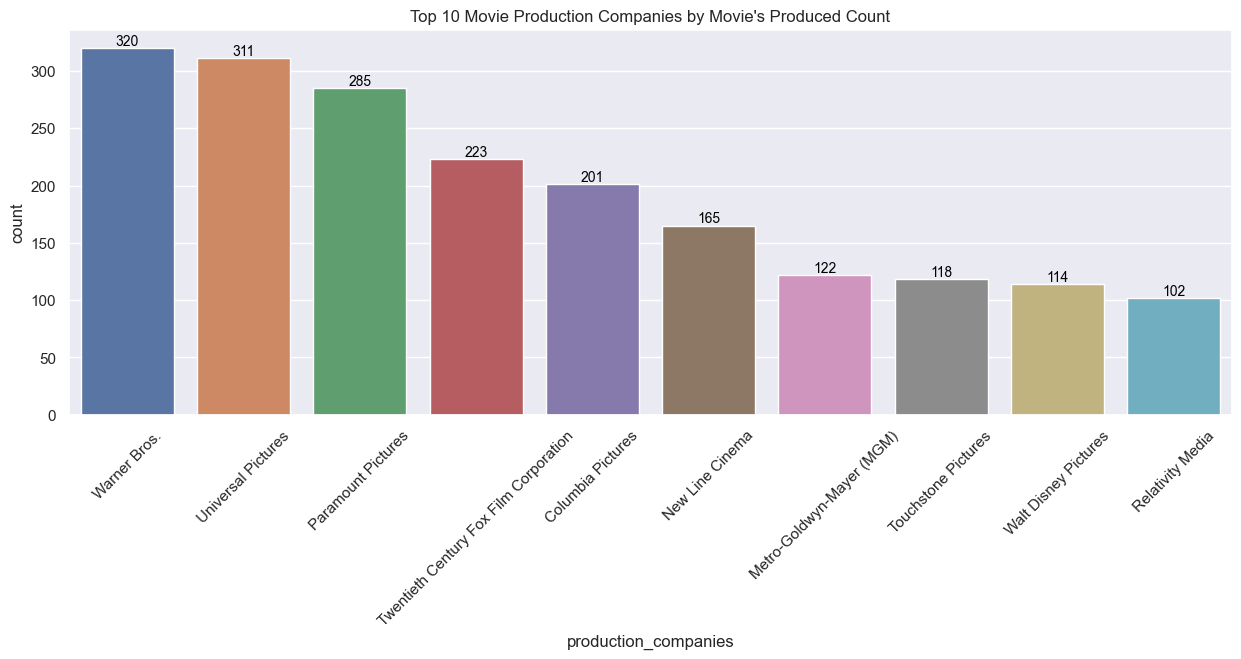

In [49]:
production_companies_df = pd.DataFrame({'production_companies': [company for sublist in movies['production_companies'] for company in sublist]})

production_companies_counts = production_companies_df['production_companies'].value_counts().sort_values(ascending=False).head(10)

top_production_companies = production_companies_counts.index

top_production_companies_df = production_companies_df[production_companies_df['production_companies'].isin(top_production_companies)]

ax3 = sb.countplot(x="production_companies", data=top_production_companies_df, order=top_production_companies)

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

for p in ax3.patches:
    ax3.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

ax3.set_title("Top 10 Movie Production Companies by Movie's Produced Count")

Text(0.5, 1.0, 'Top 10 Countries in which the Number of Movies Produced by Count')

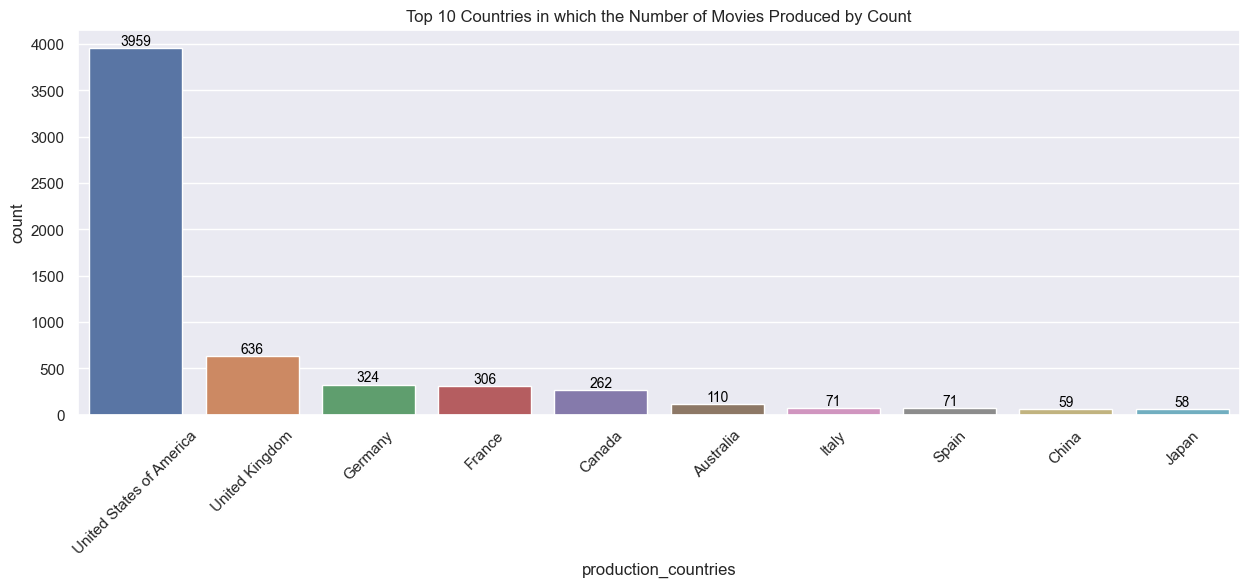

In [50]:
production_countries_df = pd.DataFrame({'production_countries': [country for sublist in movies['production_countries'] for country in sublist]})

production_countries_counts = production_countries_df['production_countries'].value_counts().sort_values(ascending=False).head(10)

top_production_countries = production_countries_counts.index

top_production_countries_df = production_countries_df[production_countries_df['production_countries'].isin(top_production_countries)]

ax4 = sb.countplot(x="production_countries", data=top_production_countries_df, order=top_production_countries)

ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)

for p in ax4.patches:
    ax4.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

ax4.set_title('Top 10 Countries in which the Number of Movies Produced by Count')

Text(0.5, 1.0, 'Top 10 Movies by Highest Budget')

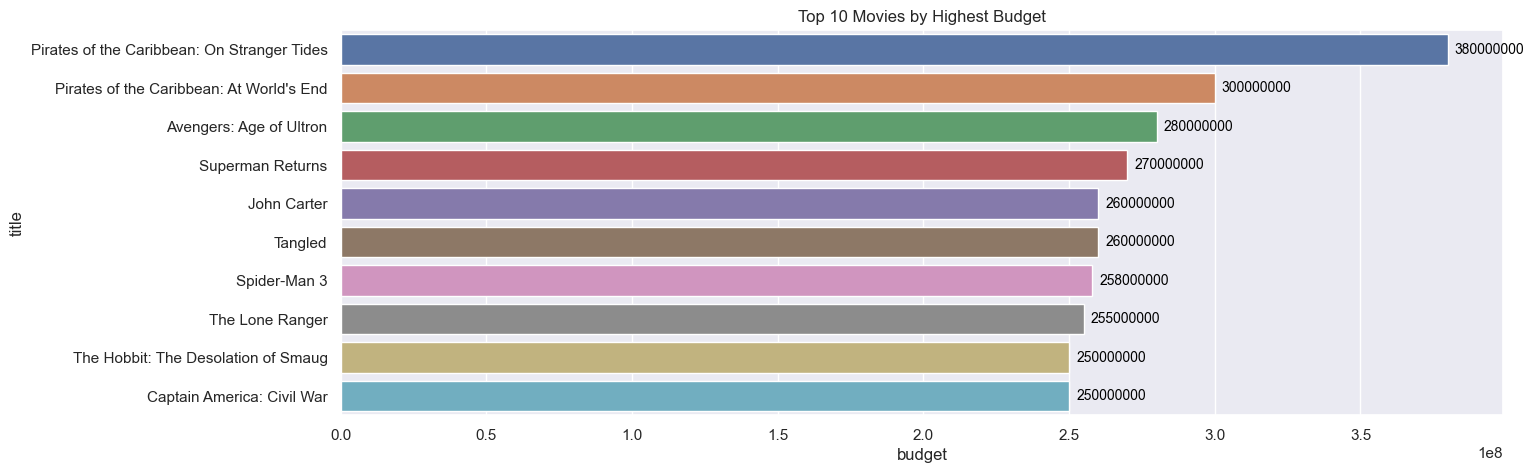

In [51]:
top_movies_by_budget = movies.sort_values("budget", ascending=False).head(10)

ax5 = sb.barplot(x="budget", y="title", data=top_movies_by_budget)

for p in ax5.patches:
    ax5.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

ax5.set_title('Top 10 Movies by Highest Budget')

Text(0.5, 1.0, 'Top 10 Movies by Popularity')

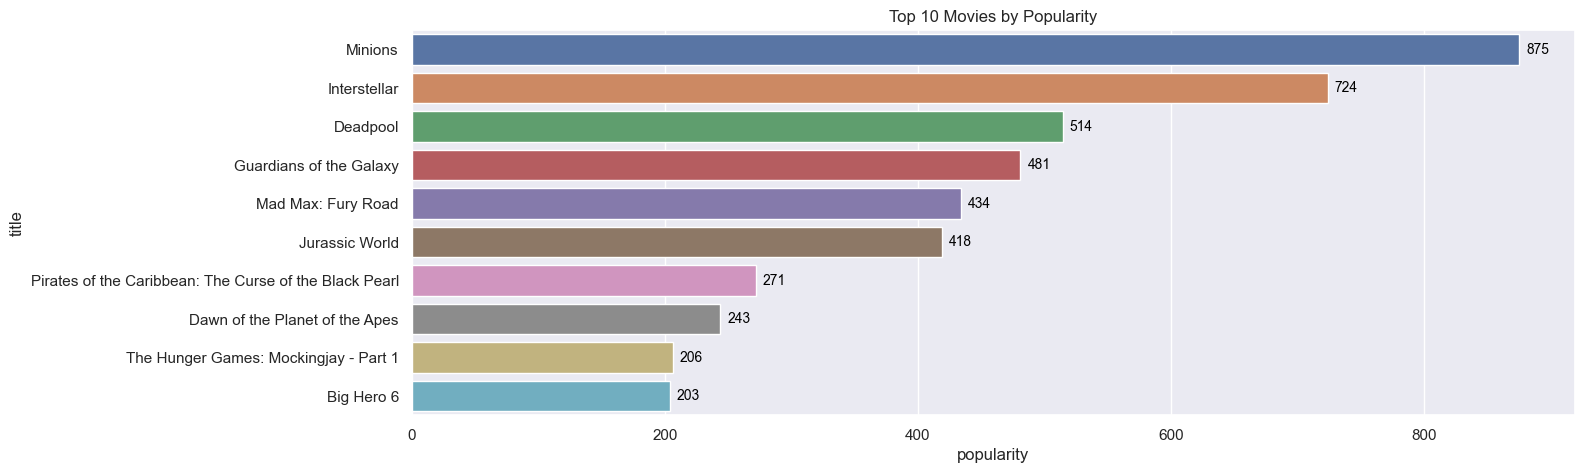

In [52]:
top_movies_by_popularity = movies.sort_values("popularity", ascending=False).head(10)

ax6 = sb.barplot(x="popularity", y="title", data=top_movies_by_popularity)

for p in ax6.patches:
    ax6.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

ax6.set_title('Top 10 Movies by Popularity')

Text(0.5, 1.0, 'Top 10 Movies by Highest Revenue')

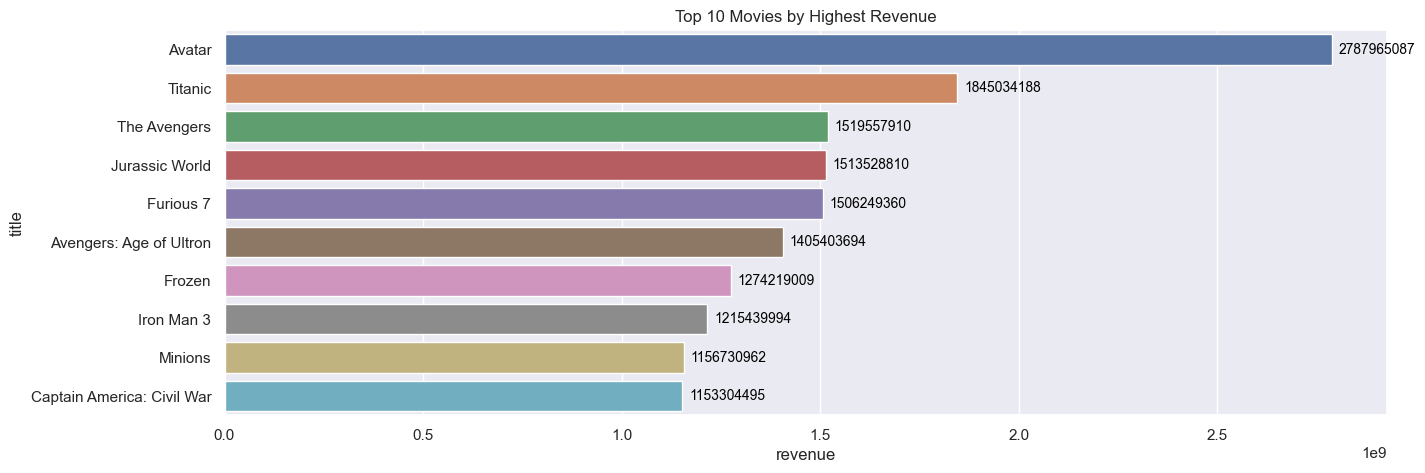

In [53]:
top_movies_by_revenue = movies.sort_values("revenue", ascending=False).head(10)

ax7 = sb.barplot(x="revenue", y="title", data=top_movies_by_revenue)

for p in ax7.patches:
    ax7.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

ax7.set_title('Top 10 Movies by Highest Revenue')

Text(0.5, 1.0, 'Top 10 Movies by Highest Runtime')

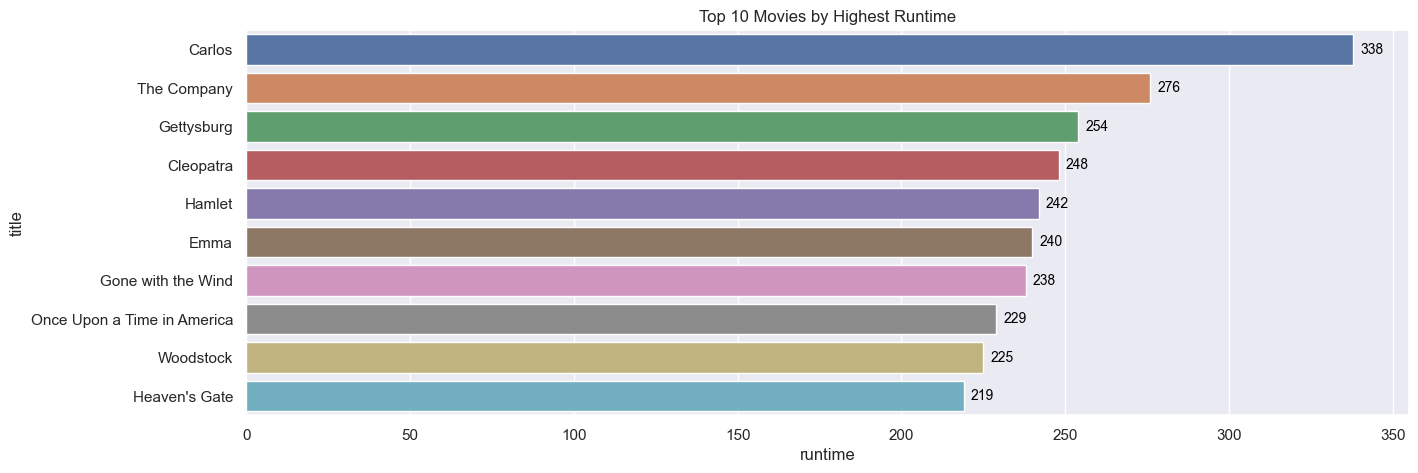

In [54]:
top_movies_by_runtime = movies.sort_values("runtime", ascending=False).head(10)

ax8 = sb.barplot(x="runtime", y="title", data=top_movies_by_runtime)

for p in ax8.patches:
    ax8.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

ax8.set_title('Top 10 Movies by Highest Runtime')

Text(0.5, 1.0, 'Top 10 Movies by Highest Vote Count')

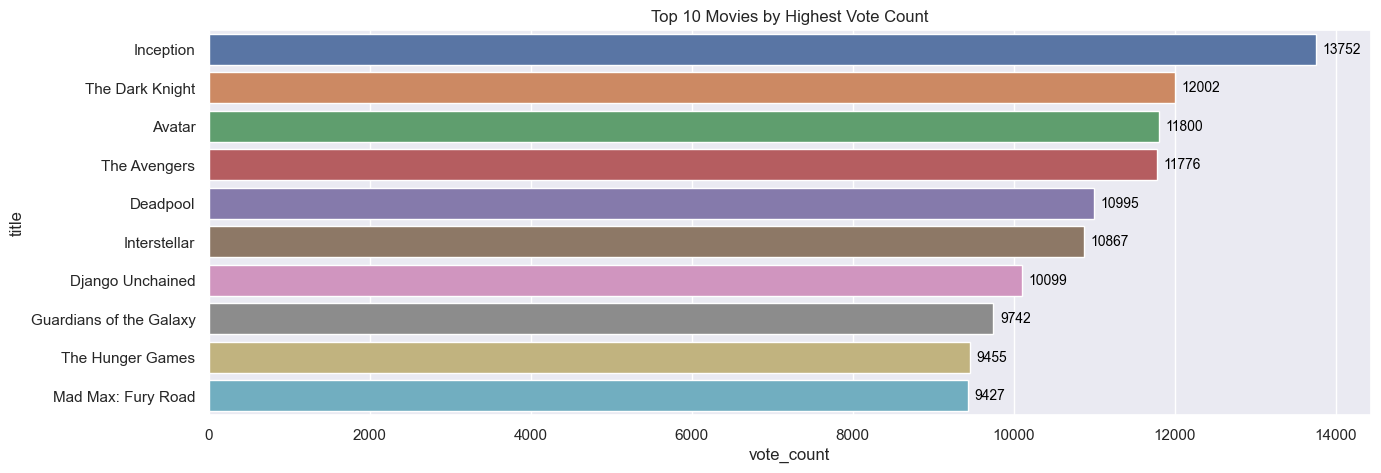

In [55]:
top_movies_by_vote_count = movies.sort_values("vote_count", ascending=False).head(10)

ax9 = sb.barplot(x="vote_count", y="title", data=top_movies_by_vote_count)

for p in ax9.patches:
    ax9.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

ax9.set_title('Top 10 Movies by Highest Vote Count')

Text(0.5, 1.0, 'Top 10 Movies by Highest Vote Average')

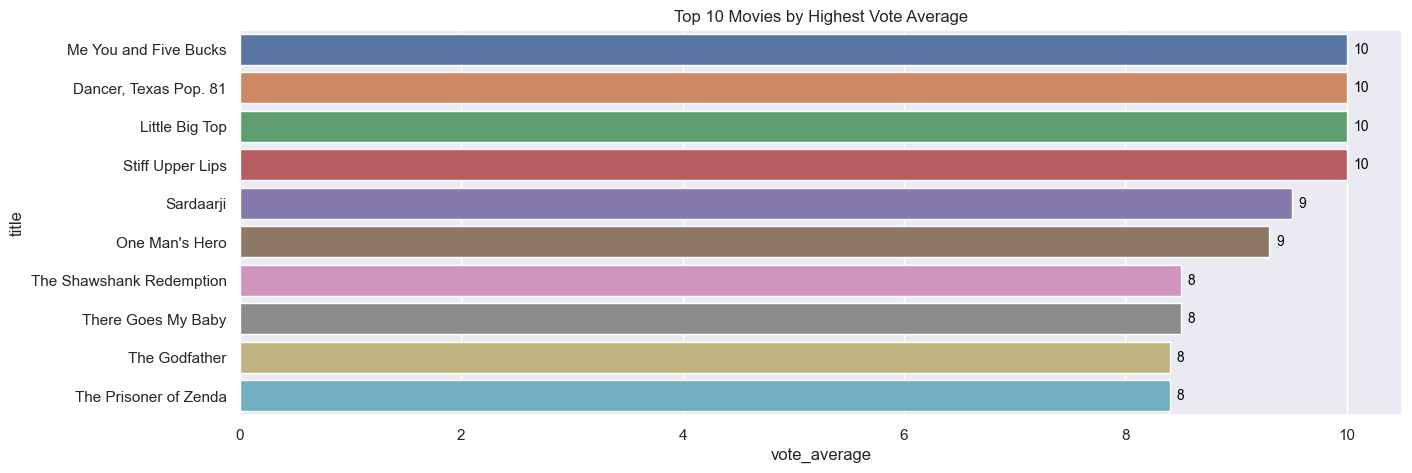

In [56]:
top_movies_by_vote_average = movies.sort_values("vote_average", ascending=False).head(10)

ax10 = sb.barplot(x="vote_average", y="title", data=top_movies_by_vote_average)

for p in ax10.patches:
    ax10.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

ax10.set_title('Top 10 Movies by Highest Vote Average')

In [57]:
def wordCloud(data,bgcolor,title):
    if all(isinstance(i, list) for i in data):
        data = [item for sublist in data for item in sublist]
    
    plt.figure(figsize = (100,100))
    
    word_cloud = WordCloud(background_color=bgcolor, max_words=1000, max_font_size=50)
    
    word_cloud.generate(' '.join(data))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.title(title, fontsize=60)
    plt.show()

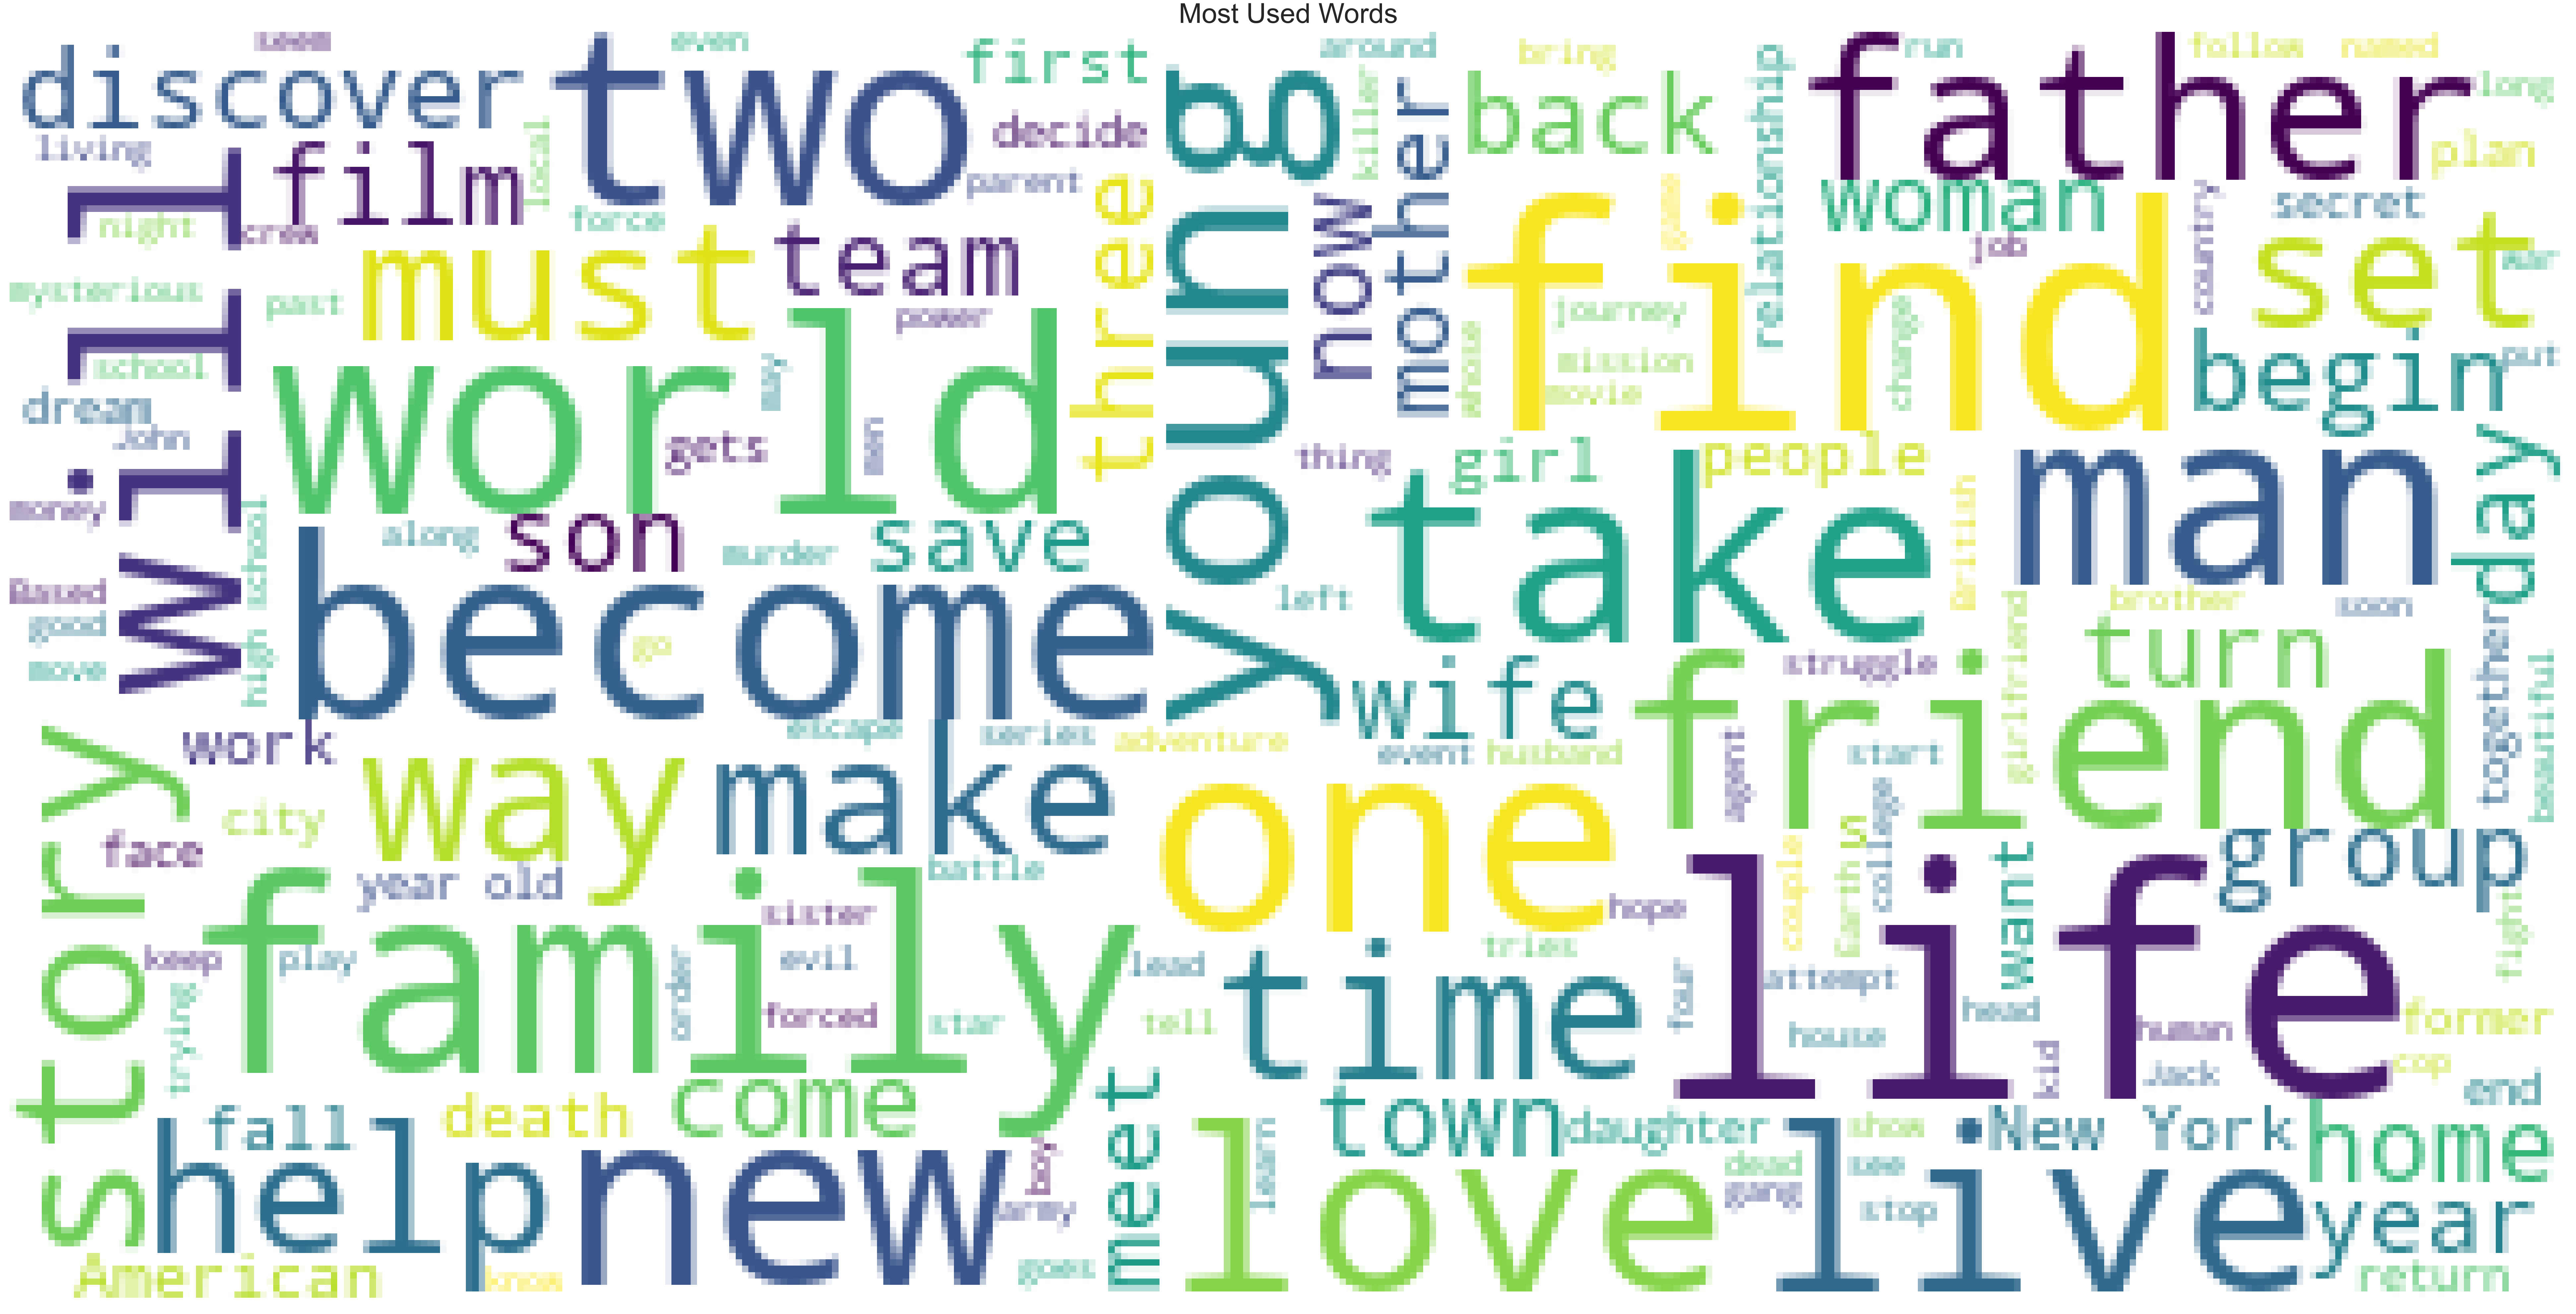

In [58]:
wordCloud(movies["overview"],"white","Most Used Words")

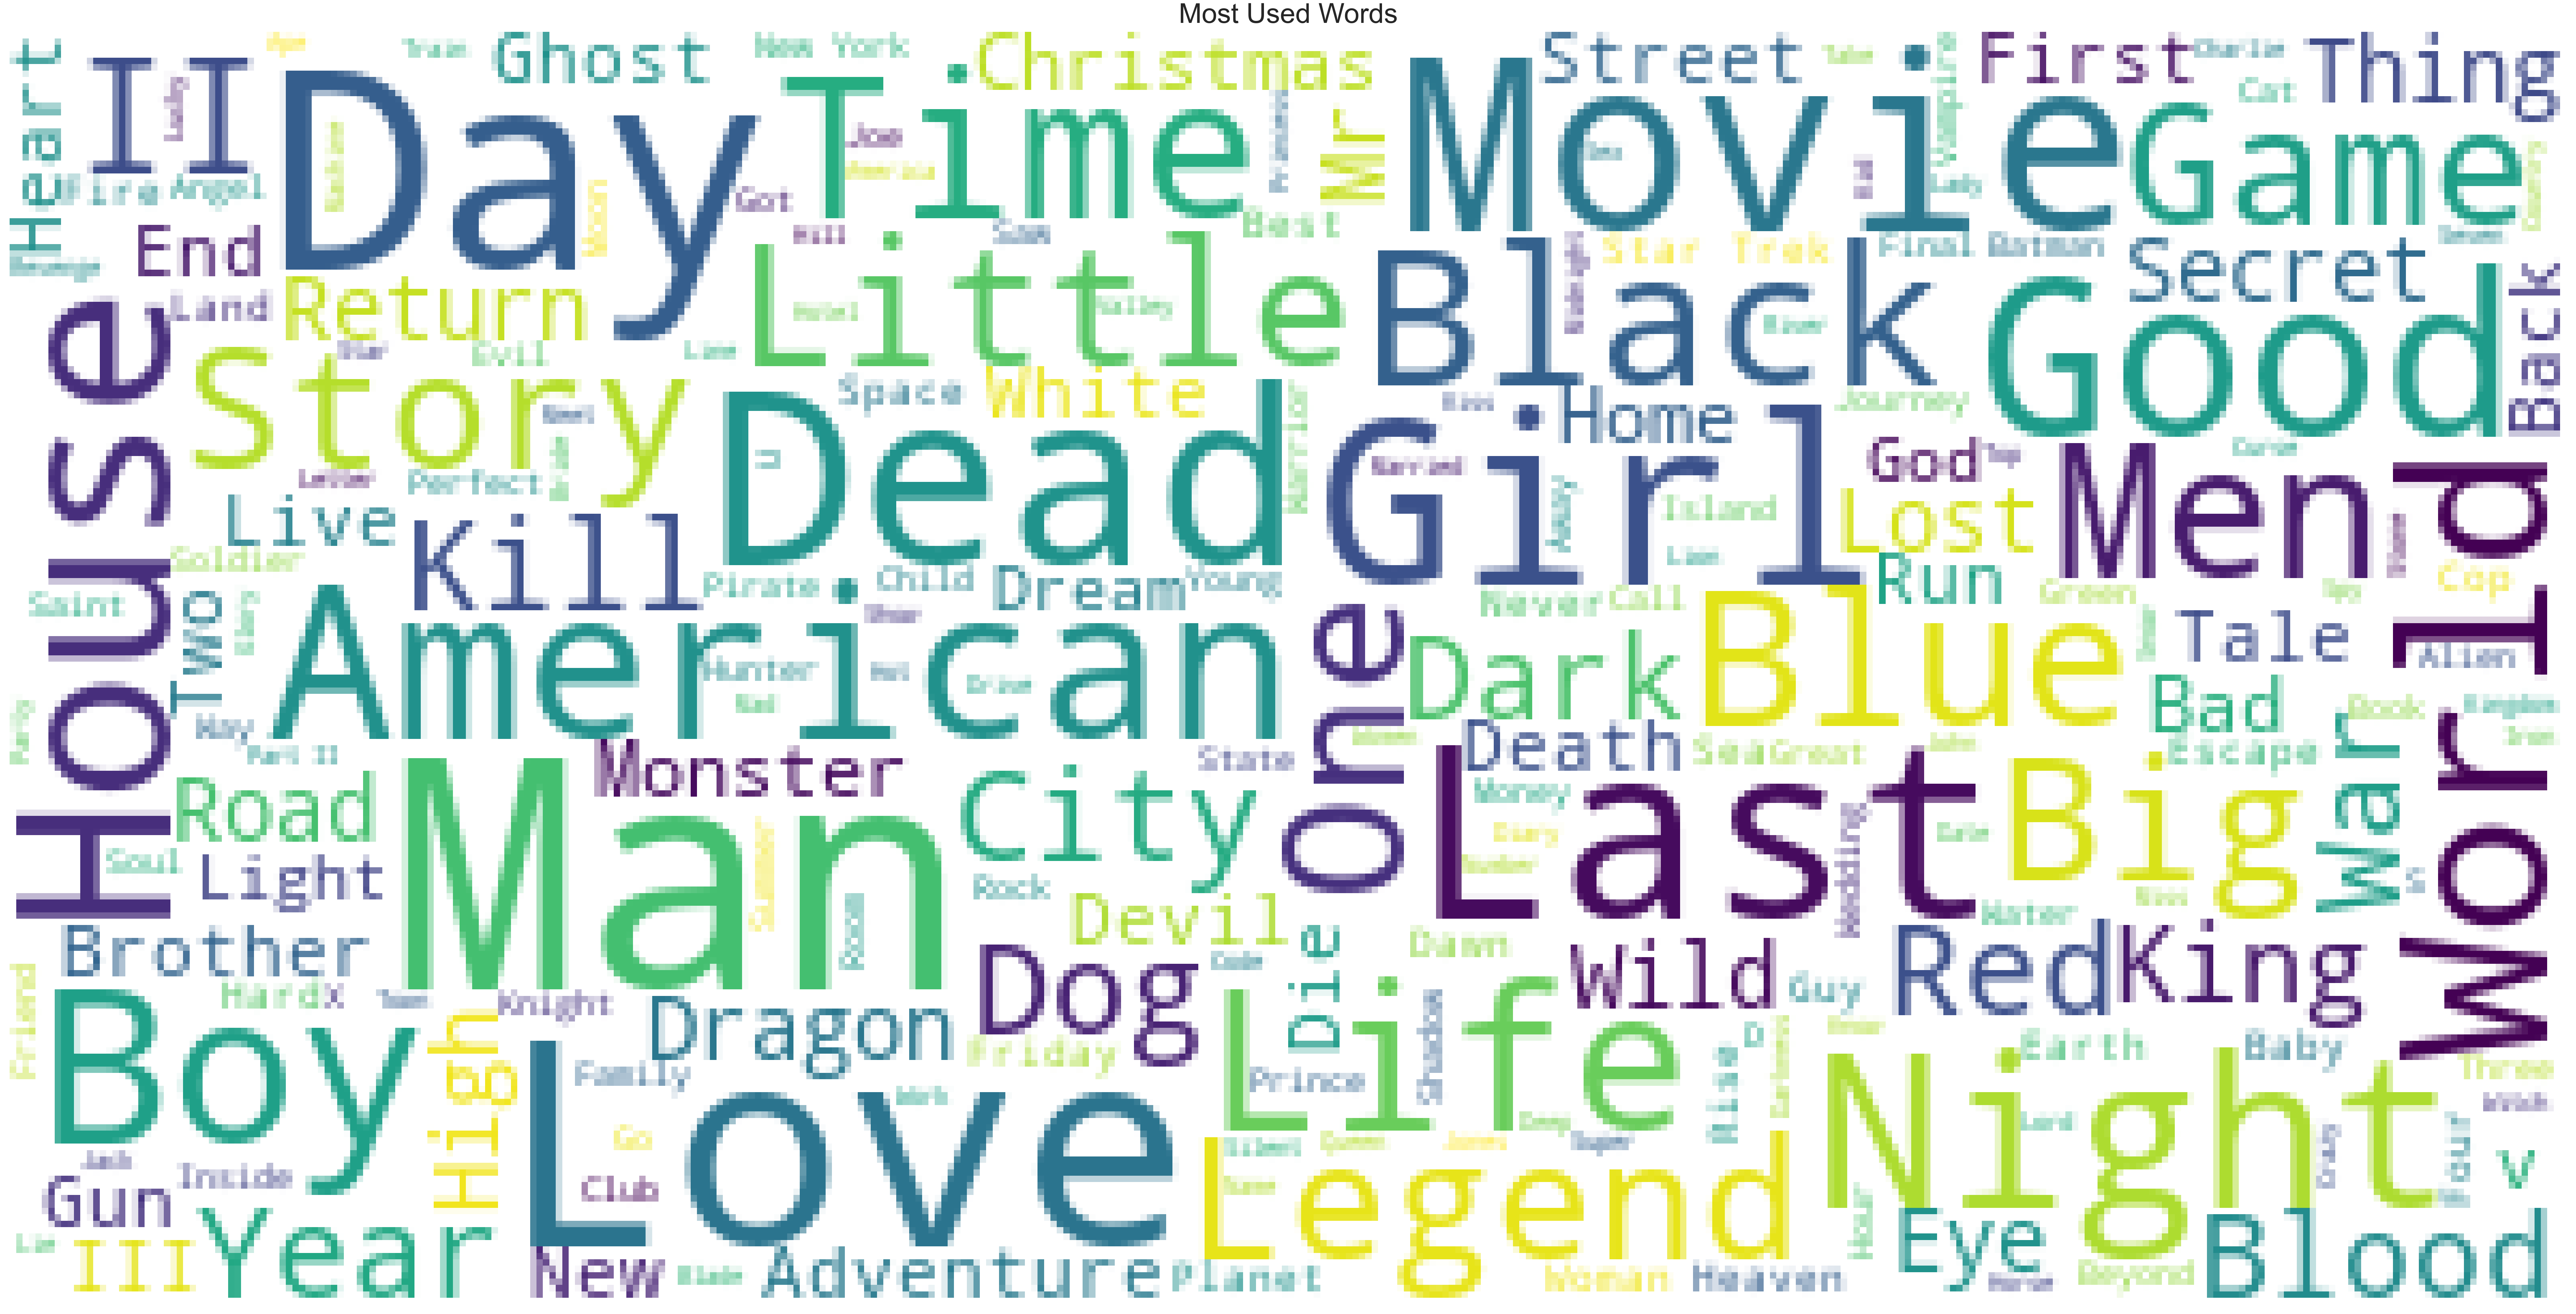

In [59]:
wordCloud(movies["title"],"white","Most Used Words")

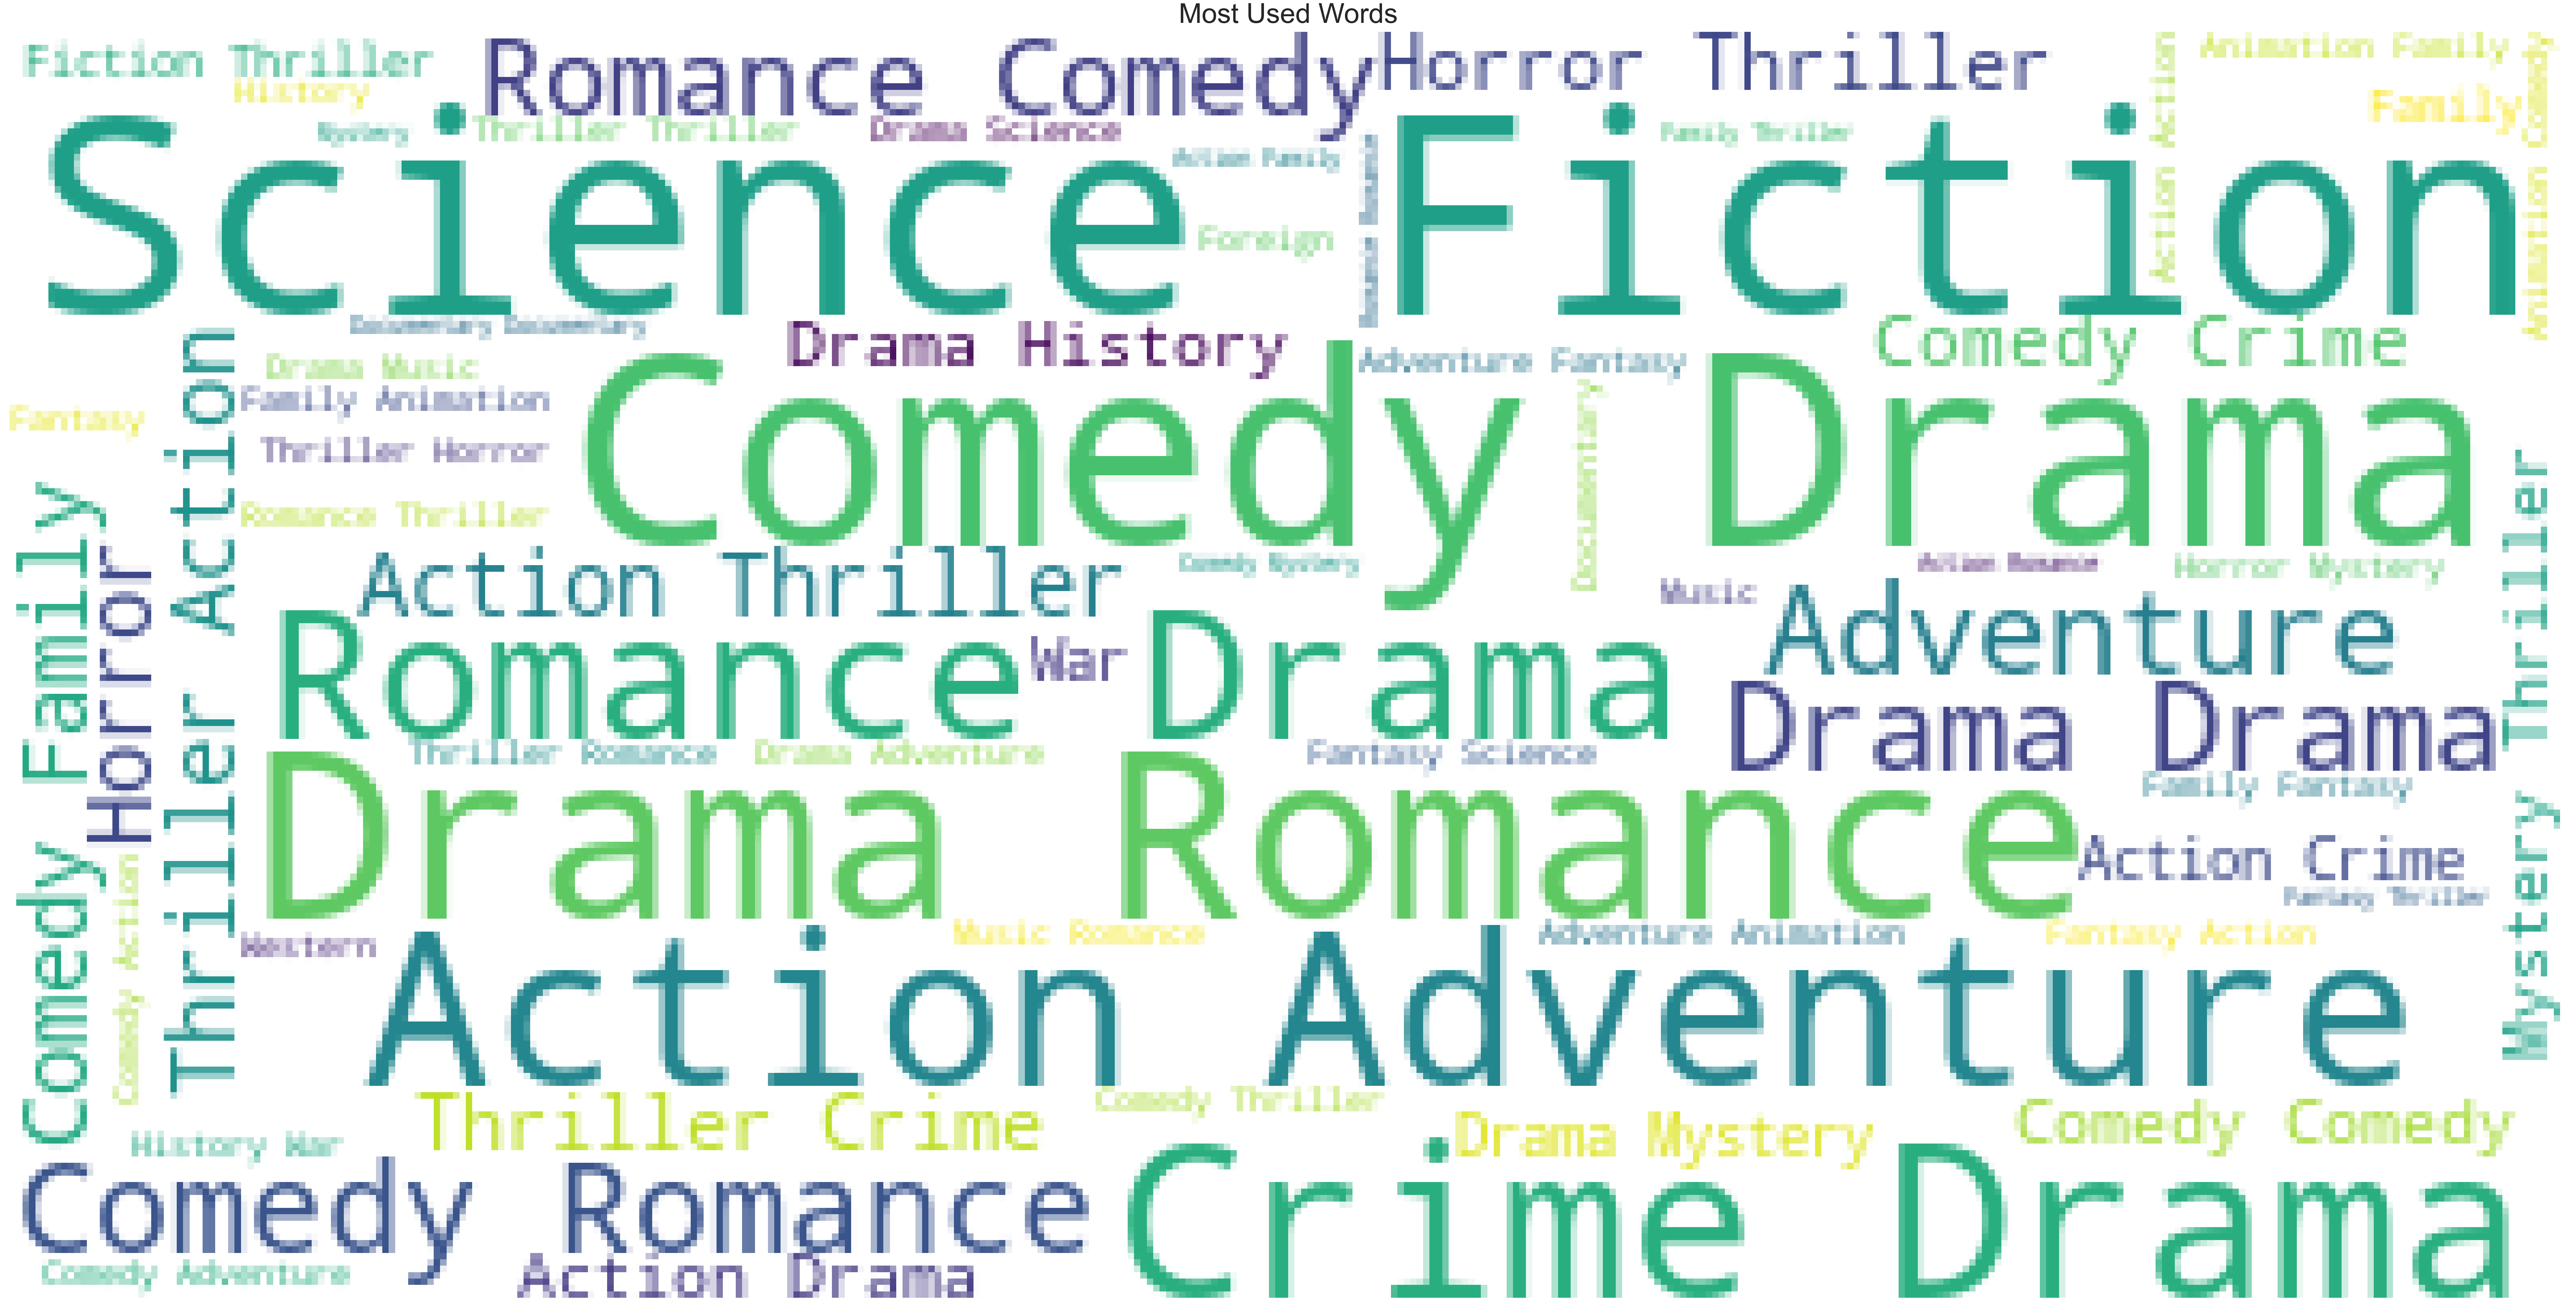

In [60]:
wordCloud(movies["genres"],"white","Most Used Words")

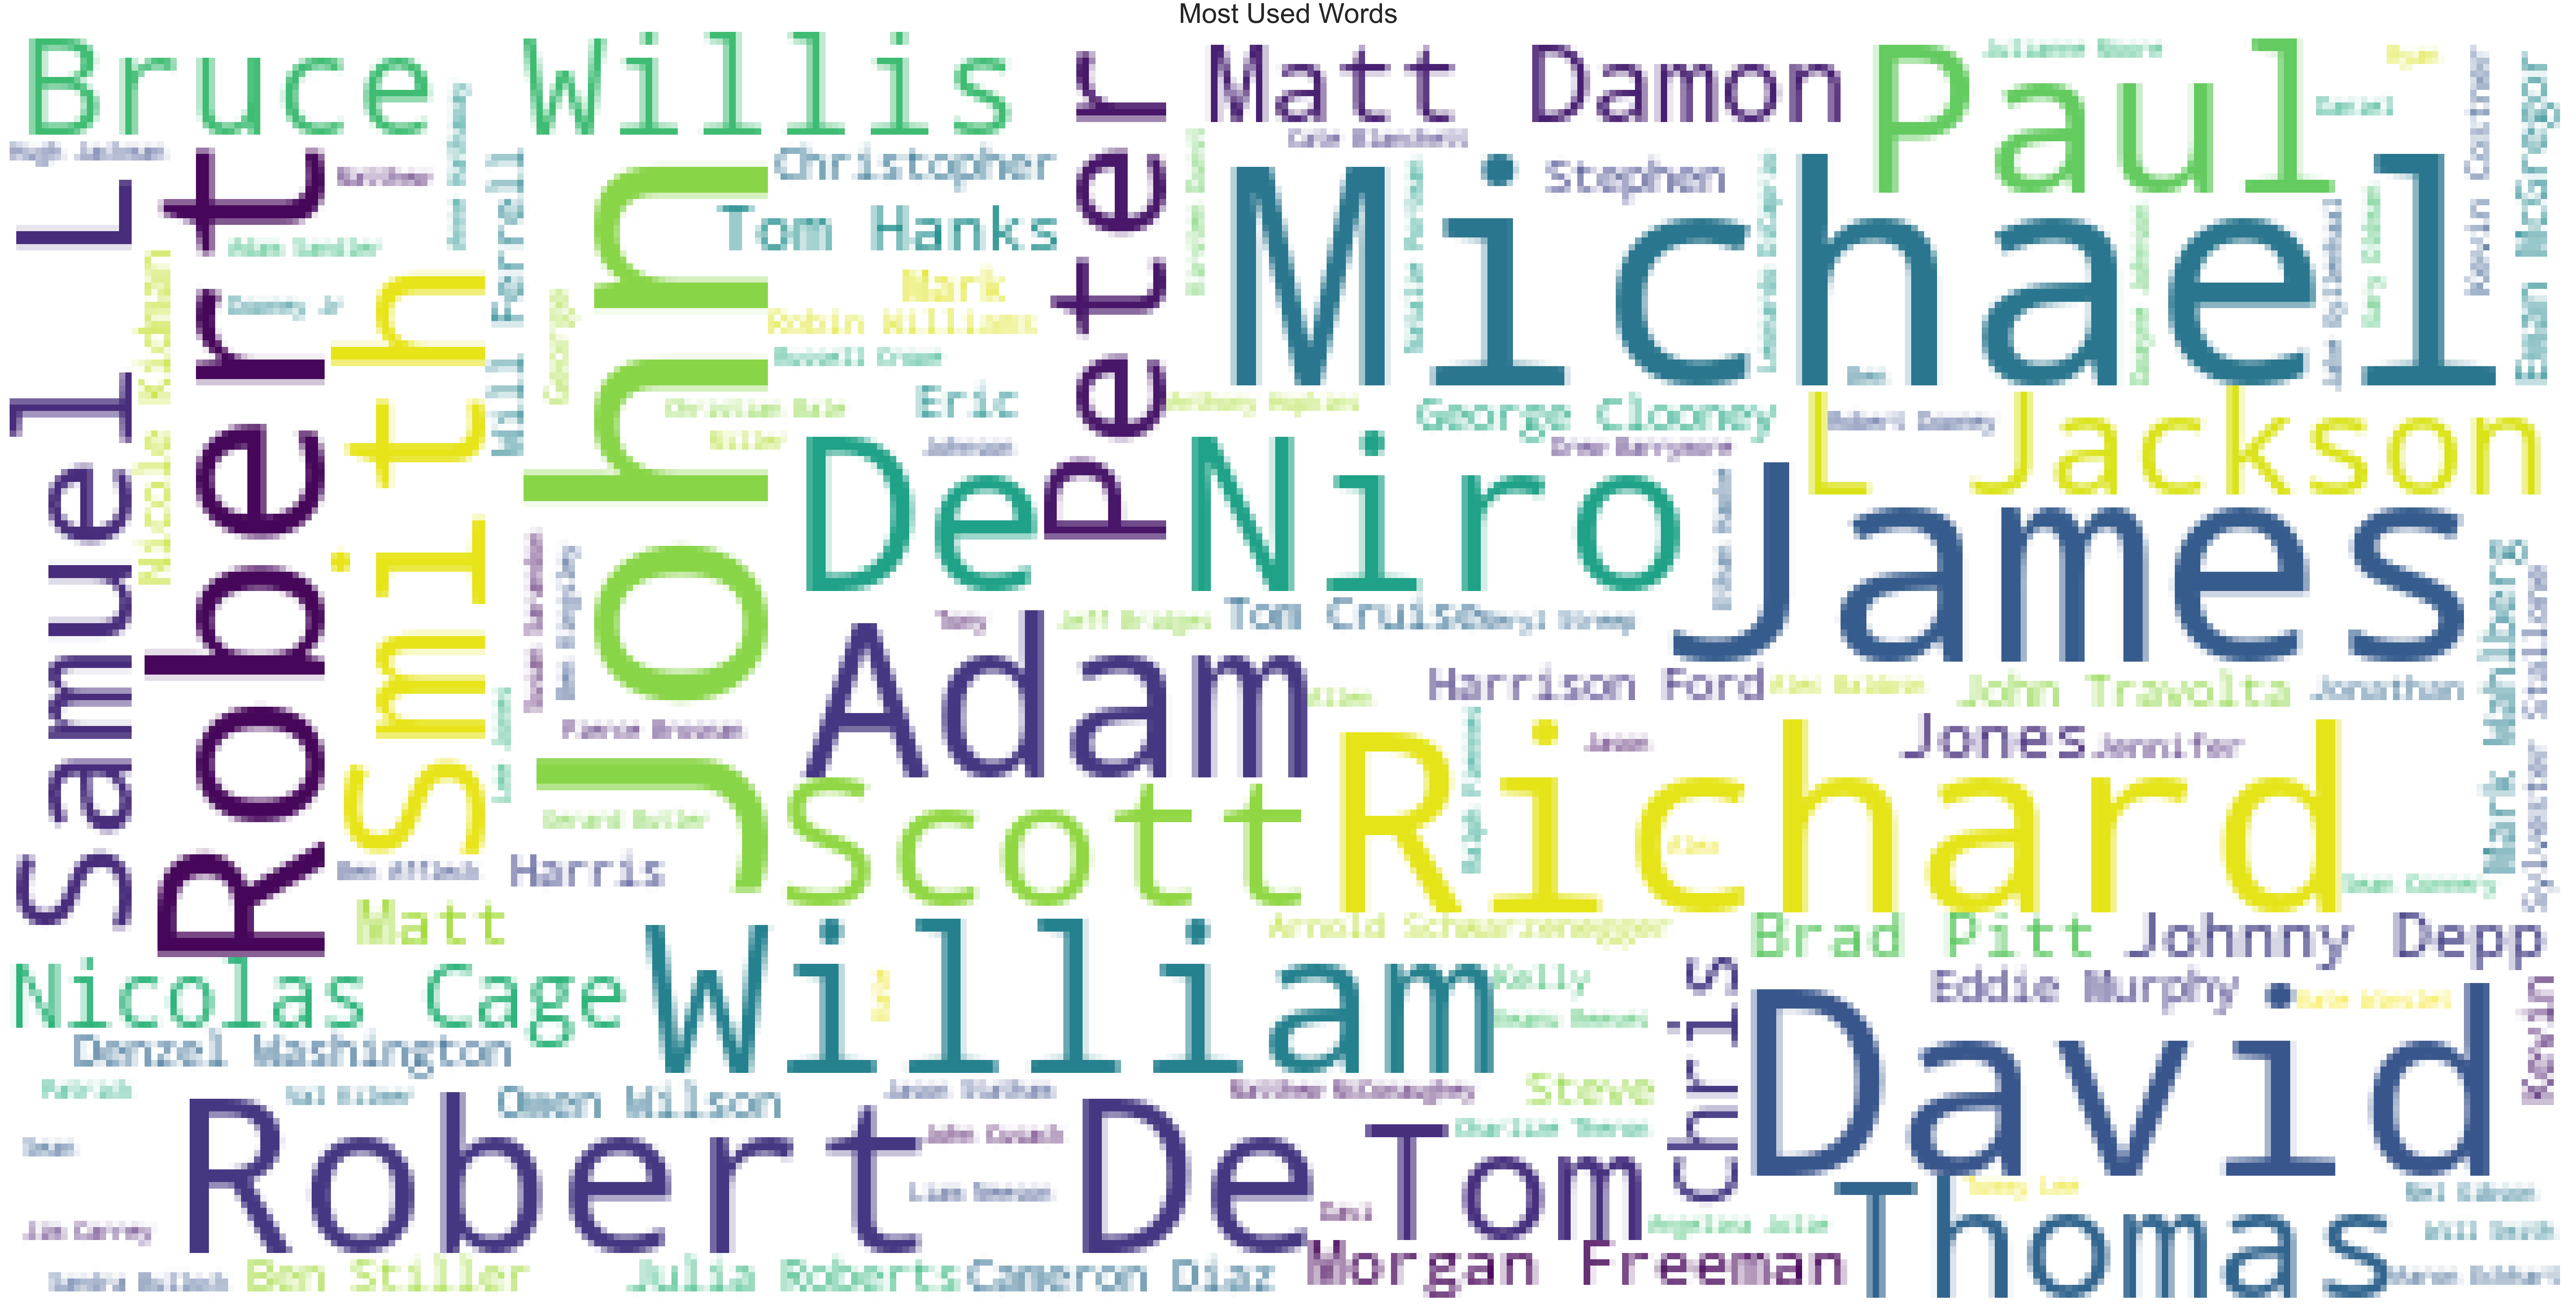

In [61]:
wordCloud(movies["cast"],"white","Most Used Words")

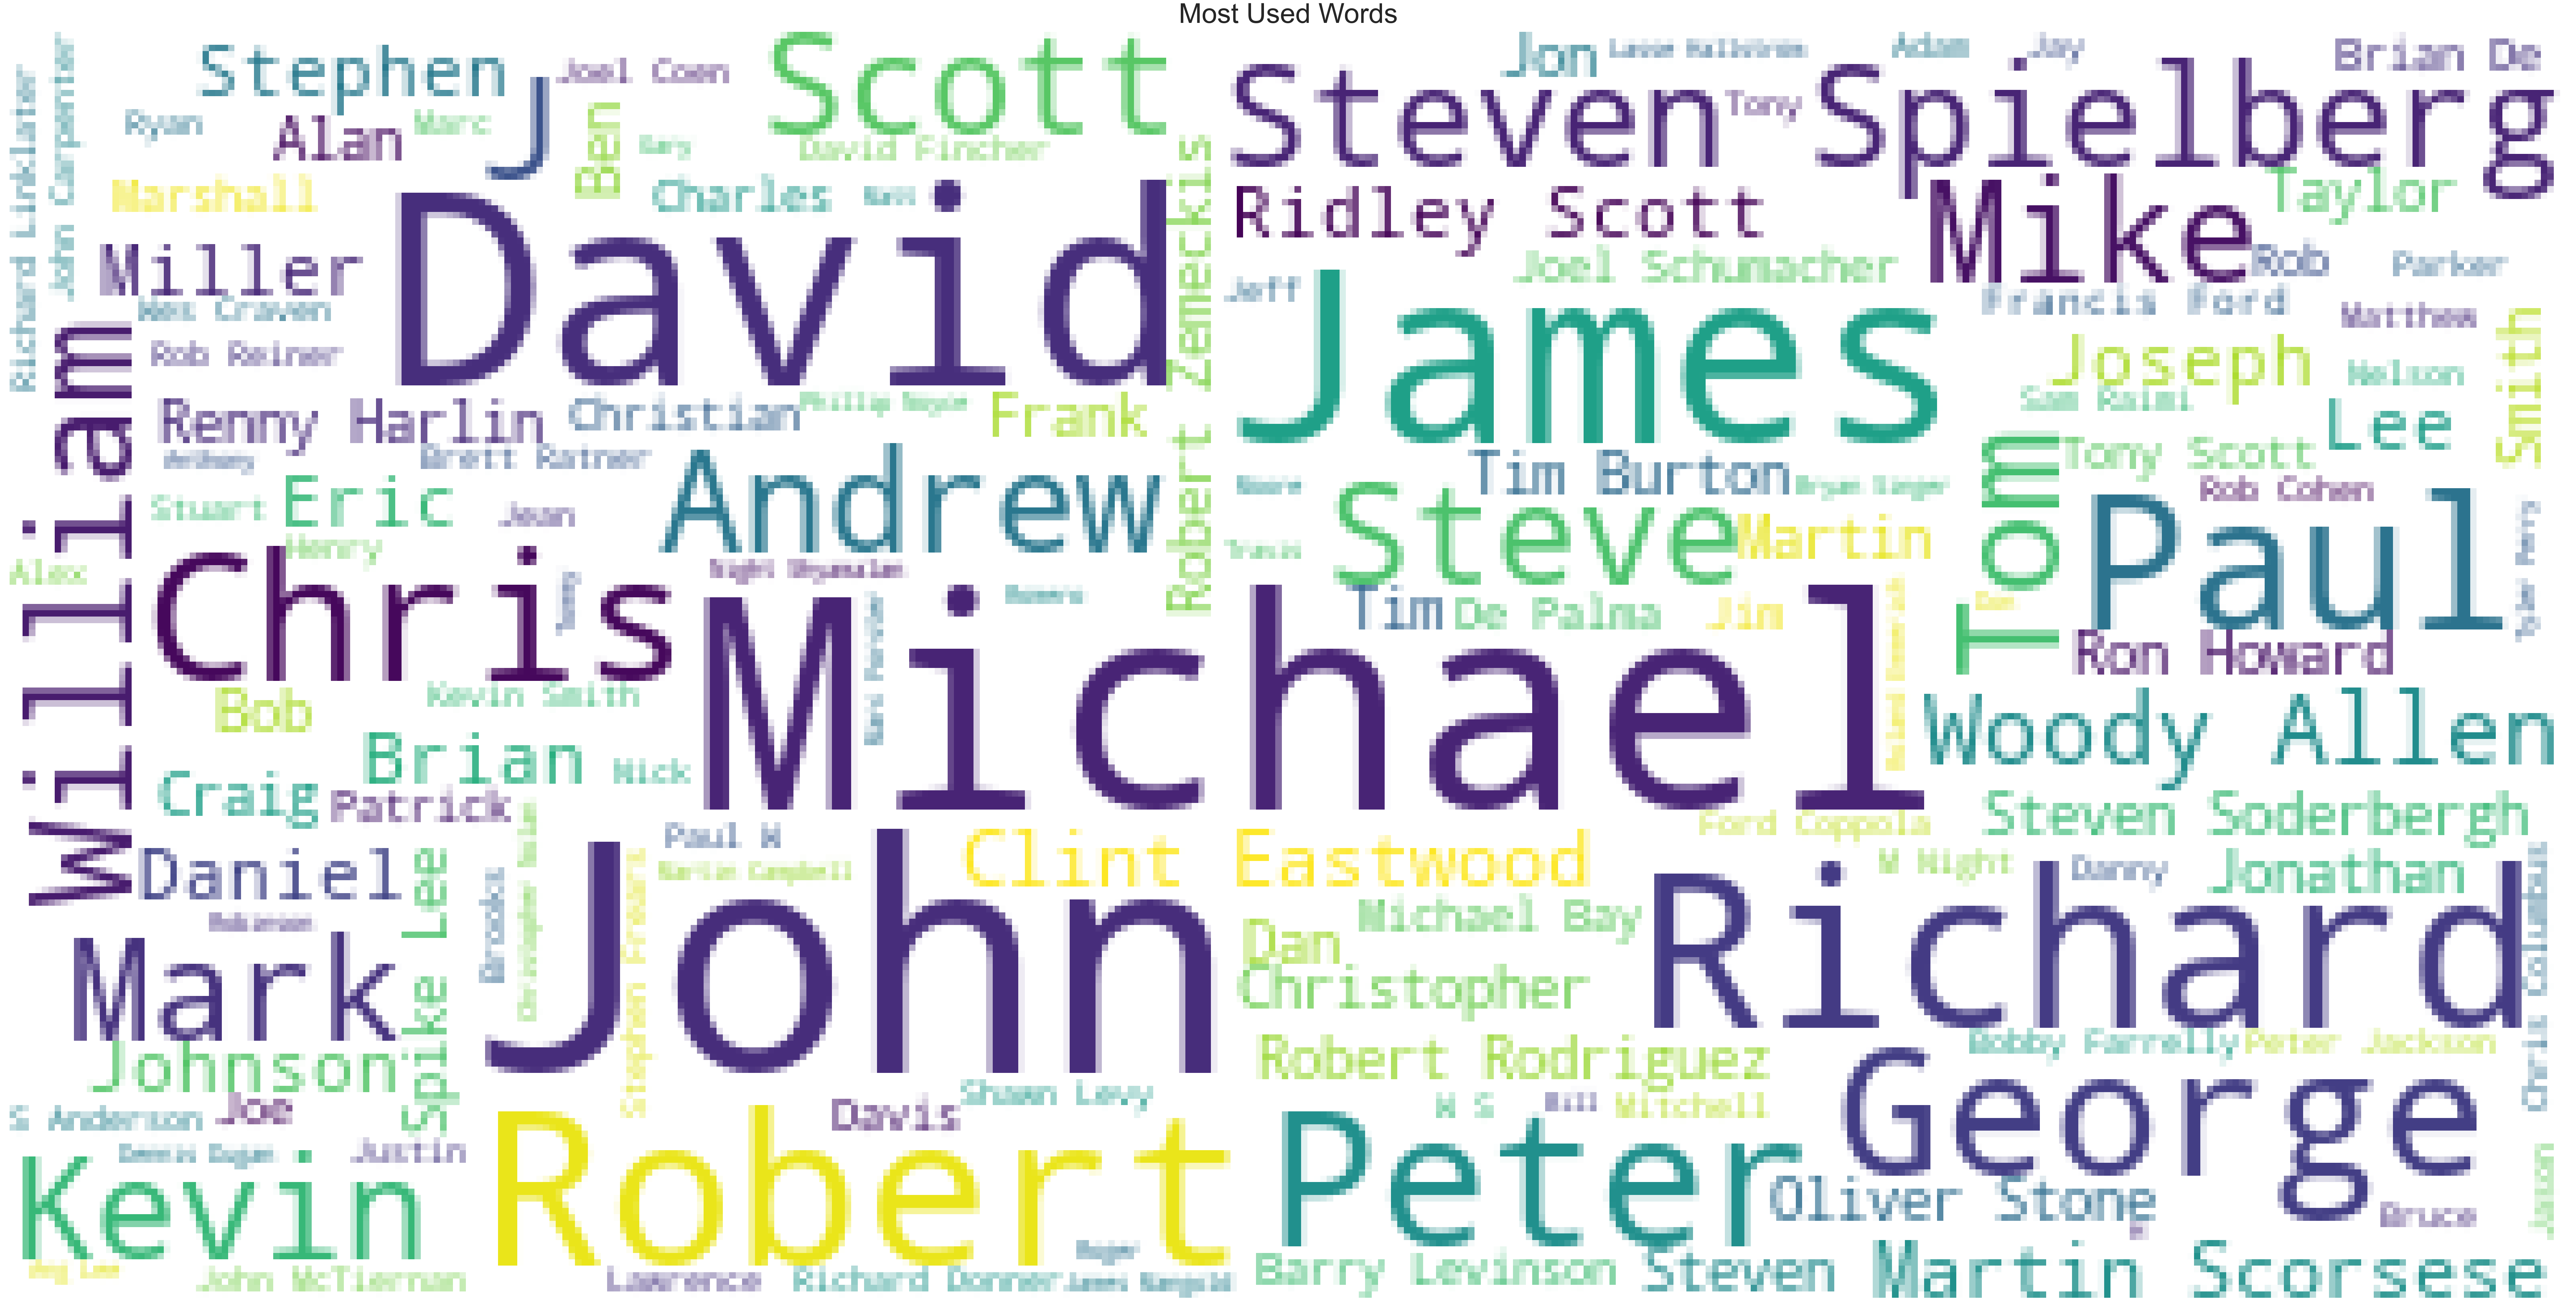

In [62]:
wordCloud(movies["crew"],r"white","Most Used Words")

## Data Preprocessing

In [63]:
movies["tags"] = movies["overview"] + movies["genres"] + movies["keywords"] + movies["cast"] + movies["crew"]

In [64]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew,vote_average,vote_count,budget,original_language,release_date,revenue,runtime,status,production_companies,production_countries,popularity,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],7.2,11800,237000000,en,2009-12-10,2787965087,162.0,Released,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",150.437577,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],6.9,4500,300000000,en,2007-05-19,961000000,169.0,Released,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],139.082615,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],6.3,4466,245000000,en,2015-10-26,880674609,148.0,Released,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",107.376788,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan],7.6,9106,250000000,en,2012-07-16,1084939099,165.0,Released,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],112.312950,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],6.1,2124,260000000,en,2012-03-07,284139100,132.0,Released,[Walt Disney Pictures],[United States of America],43.926995,"[John, Carter, is, a, war-weary,, former, mili..."


In [65]:
new_movies_df = movies[["movie_id", "title", "tags"]]

In [66]:
new_movies_df.head()

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."


In [67]:
new_movies_df["tags"] = new_movies_df["tags"].apply(lambda x: " ".join(x))

In [68]:
new_movies_df.head()

,movie_id,title,tags
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...
4,49529,John Carter,"John Carter is a war-weary, former military ca..."


In [69]:
new_movies_df["tags"] = new_movies_df["tags"].apply(lambda x: x.lower())

In [70]:
new_movies_df.head()

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."


In [71]:
porter_stemmer = PorterStemmer()

In [72]:
def stem_text(text):
    data = []

    for i in text.split():
        data.append(porter_stemmer.stem(i))

    return " ".join(data)

In [73]:
new_movies_df["tags"] = new_movies_df["tags"].apply(stem_text)

In [74]:
new_movies_df["tags"]

0       in the 22nd century, a parapleg marin is dispa...
1       captain barbossa, long believ to be dead, ha c...
2       a cryptic messag from bond’ past send him on a...
3       follow the death of district attorney harvey d...
4       john carter is a war-weary, former militari ca...
                              ...                        
4804    el mariachi just want to play hi guitar and ca...
4805    a newlyw couple' honeymoon is upend by the arr...
4806    "signed, sealed, delivered" introduc a dedic q...
4807    when ambiti new york attorney sam is sent to s...
4808    ever sinc the second grade when he first saw h...
Name: tags, Length: 4805, dtype: object

In [75]:
new_movies_df["tags"].iloc[0]

'in the 22nd century, a parapleg marin is dispatch to the moon pandora on a uniqu mission, but becom torn between follow order and protect an alien civilization. action adventur fantasi scienc fiction cultur clash futur space war space coloni societi space travel futurist romanc space alien tribe alien planet cgi marin soldier battl love affair anti war power relat mind and soul 3d sam worthington zoe saldana sigourney weaver jame cameron'

In [76]:
first_model_x = new_movies_df["tags"]
first_model_y = new_movies_df["title"]

## Model Building Using CountVectorizer

In [77]:
count_vectorizer = CountVectorizer(max_features=5000, stop_words="english").fit(first_model_x)

first_review = count_vectorizer.transform(first_model_x)

X_train, X_test, y_train, y_test = train_test_split(first_model_x, first_model_y, test_size=0.3, random_state=42)

In [78]:
count_vectorizer

CountVectorizer(max_features=5000, stop_words='english')

In [79]:
vectors = count_vectorizer.fit_transform(first_model_x).toarray()

In [80]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [81]:
len(vectors[1])

5000

In [82]:
count_vectorizer.get_feature_names_out()

array(['000', '007', '10', ..., 'zooey', 'zucker', 'zwick'], dtype=object)

In [83]:
similarity = cosine_similarity(vectors)

In [84]:
similarity[0]

array([1.        , 0.06692745, 0.06554735, ..., 0.04442617, 0.03244428,
       0.        ])

In [85]:
def recommend_movies(movie, new_movies_df, similarity):
    try:
        if movie in new_movies_df['title'].values:
            movie_index = new_movies_df[new_movies_df['title'] == movie].index[0]
            distances = similarity[movie_index]
            movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]
            
            recommended_titles = []
    
            for i in movies_list:
                recommended_titles.append(new_movies_df.iloc[i[0]].title)
            
            return recommended_titles
        else:
            return []
    except Exception:
        return []

In [86]:
recommend_movies("Avatar", new_movies_df, similarity)

['Aliens', 'Silent Running', 'Moonraker', 'Alien', 'Mission to Mars']

In [87]:
recommend_movies("Batman Begins", new_movies_df, similarity)

['The Dark Knight',
 'The Dark Knight Rises',
 'Batman',
 'Batman',
 'Batman & Robin']

In [88]:
recommend_movies("Harry Potter and the Order of the Phoenix", new_movies_df, similarity)

['Harry Potter and the Chamber of Secrets',
 'Harry Potter and the Goblet of Fire',
 "Harry Potter and the Philosopher's Stone",
 'Harry Potter and the Prisoner of Azkaban',
 'Harry Potter and the Half-Blood Prince']

In [89]:
def evaluate_model(model, test_data):
    predictions = []
    
    for movie in new_movies_df["tags"]:
        predictions.append(model(movie, new_movies_df, similarity))
    
    return predictions

predictions = evaluate_model(recommend_movies, X_test)
actual_recommendations = [recommend_movies(movie, new_movies_df, similarity) for movie in y_test]

In [90]:
X_train, X_test = train_test_split(new_movies_df, test_size=0.2, random_state=42)

def evaluate_model(model, test_data):
    predictions = []
    
    for movie in test_data["title"]:
        predictions.append(model(movie, new_movies_df, similarity))
    
    return predictions

predictions = evaluate_model(recommend_movies, X_test)
actual_recommendations = [recommend_movies(movie, new_movies_df, similarity) for movie in X_test["title"]]

In [91]:
p = recommend_movies(X_train["title"].iloc[0], new_movies_df, similarity)

In [92]:
p

['U.F.O.', 'They Live', 'The Host', 'Home', 'Aliens vs Predator: Requiem']

In [93]:
def calculate_precision_recall_f1(actual, predicted):
    TP = 0
    FP = 0
    FN = 0

    for i in range(len(actual)):
        actual_set = set(actual[i])
        predicted_set = set(predicted[i])
        TP += len(actual_set & predicted_set)
        FP += len(predicted_set - actual_set)
        FN += len(actual_set - predicted_set)

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score

In [94]:
precision, recall, f1 = calculate_precision_recall_f1(actual_recommendations, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


**The Precision, Recall, and F1 Score value is "1". It either means that our model is working too well or it's over-fitting.**

## Model Bulding using TfidfVectorizer and KNN

In [95]:
new_movies_df["movie_id"].duplicated().sum()

6

**There are some duplicate values. Let's remove them.**

In [96]:
new_movies_df.drop_duplicates(inplace=True, subset="movie_id")

In [97]:
new_movies_df["movie_id"].duplicated().sum()

0

In [98]:
tfidf_vectorizer = TfidfVectorizer()

In [99]:
tfidf_matrix = tfidf_vectorizer.fit_transform(first_model_x)

In [100]:
spm = new_movies_df.pivot(index="movie_id", columns="title", values="tags").fillna(0)

In [101]:
spm.head()

title,#Horror,(500) Days of Summer,10 Cloverfield Lane,10 Days in a Madhouse,10 Things I Hate About You,102 Dalmatians,10th & Wolf,11:14,12 Angry Men,12 Rounds,...,Zoolander,Zoolander 2,Zoom,Zulu,[REC],[REC]²,eXistenZ,xXx,xXx: State of the Union,Æon Flux
movie_id,,,,,,,,,,,,,,,,,,,,,
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
mat_movies = csr_matrix(tfidf_matrix)

In [103]:
model = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=20)
model.fit(mat_movies)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [104]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(new_movies_df['tags'])
model = NearestNeighbors().fit(tfidf_matrix)

def recommender_knn(movie_name, data, model, n):
    idx = process.extractOne(movie_name, data["title"])[2]
    movie_vector = tfidf_matrix[idx]
    distances, indices = model.kneighbors(movie_vector, n_neighbors=20)
    recommended_list = []
    
    for i in indices.flatten():
        if i != idx:
            recommended_list.append(data.iloc[i]["title"])

    return recommended_list[1: 6]

In [105]:
recommender_knn("Avatar", new_movies_df, model, 6)

['Alien³', 'Alien', 'Mission to Mars', 'Moonraker', 'Treasure Planet']

In [106]:
recommender_knn("Batman Begins", new_movies_df, model, 6)

['The Dark Knight Rises',
 'Batman',
 'Batman',
 'Batman Returns',
 'Batman v Superman: Dawn of Justice']

In [107]:
recommender_knn("Birth", new_movies_df, model, 6)

['Masked and Anonymous', 'Once', 'Bandslam', 'Walk the Line', 'The Last Waltz']

In [108]:
def evaluate_model(model, test_data):
    predictions = []

    for movie in test_data["title"]:
        predictions.append(recommender_knn(movie, new_movies_df, model, 6))
    
    return predictions[1:6]

X_train, X_test = train_test_split(new_movies_df, test_size=0.2, random_state=42)

predictions = evaluate_model(model, X_test.head(5))

In [109]:
def evaluate_actual(model, test_data):
    perdictions = []

    for movie in test_data["title"]:
        predictions.append(recommender_knn(movie, new_movies_df, model, 6))

    return predictions

actual = evaluate_actual(model, X_test.head(5))

In [110]:
def calculate_precision_recall_f1(actual, predicted):
    TP = 0
    FP = 0
    FN = 0

    for i in range(len(actual)):
        actual_set = set(actual[i])
        predicted_set = set(predicted[i])
        TP += len(actual_set & predicted_set)
        FP += len(predicted_set - actual_set)
        FN += len(actual_set - predicted_set)

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score

In [111]:
precision, recall, f1 = calculate_precision_recall_f1(actual, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


**The Precision, Recall, and F1 Score value is "1".**

## Saving data in "pickle" files

In [112]:
pickle.dump(movies.to_dict(), open("files/movies.pkl", "wb"))

In [113]:
pickle.dump(new_movies_df.to_dict(), open("files/new_movies_df.pkl", "wb"))

In [114]:
pickle.dump(similarity, open("files/similarity.pkl", "wb"))

In [115]:
pickle.dump(spm, open("files/spm.pkl", "wb"))